In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
embedding_folder = '/home/jupyter/research/models'

In [3]:
model_names = [
    'resnet18', 'resnet34', 'resnet50', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2','efficientnet-b3',
    'resnext', 'densenet', 'vgg', 'mobilenet', 'vit', 'cvit', 'bvc', 'birdnet-realtime'
]

# all_embeddings = [resnet18_embeddings,
#                 resnet34_embeddings,
#                 resnet50_embeddings,
#                 efficientnet-b0_embeddings,
#                 efficientnet-b1_embeddings,
#                 efficientnet-b2_embeddings,
#                 efficientnet-b3_embeddings,
#                 resnext_embeddings,
#                 densenet_embeddings,
#                 alexnet_embeddings,
#                 vgg_embeddings,
#                 mobilenet_embeddings,
#                 vit_embeddings,
#                 cvit_embeddings,
#                 bvc_embeddings,
#                 birdnet_embeddings_train,
#                 birdnet_embeddings]

# all_labels = [labels]*12 + [vit_labels,cvit_labels,bvc_labels,birdnet_labels_train,birdnet_labels]

In [4]:
def load_embeddings_labels(model_folder,model_name):
    embeddings = np.load(os.path.join(embedding_folder,model_name+'_embeddings.npy'))
    labels = np.load(os.path.join(embedding_folder,model_name+'_labels.npy'))
    return embeddings, labels

In [5]:
model_embeddings = {}
model_labels = {}

for model in model_names:
    model_embeddings[model],model_labels[model] = load_embeddings_labels(embedding_folder,model)
    

### Silhouette Score, Davies-Bouldin Index, Within-Cluster Sum of Squares

In [6]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

In [7]:
# Define the calculate_silhouette_score and calculate_db_index functions
def calculate_silhouette_score(embeddings, labels):
    from sklearn.metrics import silhouette_score
    score = silhouette_score(embeddings, labels)
    # return round(score, 2)
    return f"{score:.2f}"

def calculate_db_index(embeddings, labels):
    from sklearn.metrics import davies_bouldin_score
    score = davies_bouldin_score(embeddings, labels)
    return f"{score:.2f}"

def calculate_ch_score(embeddings, labels):
    from sklearn.metrics import calinski_harabasz_score

    score = calinski_harabasz_score(embeddings, labels)
    return f"{score:.2f}"


# def calculate_ari()
# ari = adjusted_rand_score(labels, labels)
# nmi = normalized_mutual_info_score(labels, labels)


In [8]:
# # Iterate over model names, embeddings, and labels
# for model_name in model_names:
#     print(f'Model: {model_name}\n')    
#     # Silhouette Score
#     silhouette_avg = calculate_silhouette_score(model_embeddings[model_name],model_labels[model_name])
#     print(f'Silhouette Score: {silhouette_avg}')

#     # Davies-Bouldin Index
#     db_index = calculate_db_index(model_embeddings[model_name],model_labels[model_name])
#     print(f'Davies-Bouldin Index: {db_index}')
    
#     ch = calculate_ch_score(model_embeddings[model_name],model_labels[model_name])
#     print(f"The Calinski-Harabasz Index is: {ch}")
    
#     print('\n')

In [9]:
import numpy as np
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix

def dunn_index(X, labels):
    distances = distance_matrix(X, X)
    unique_labels = np.unique(labels)
    
    min_inter_cluster_distance = np.inf
    max_intra_cluster_distance = 0
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            cluster_distances = distances[np.ix_(labels == label, labels == label)]
            max_intra_cluster_distance = max(max_intra_cluster_distance, np.max(cluster_distances))
        
        for other_label in unique_labels:
            if label != other_label:
                inter_cluster_distances = distances[np.ix_(labels == label, labels == other_label)]
                min_inter_cluster_distance = min(min_inter_cluster_distance, np.min(inter_cluster_distances))
    
    return min_inter_cluster_distance / max_intra_cluster_distance if max_intra_cluster_distance > 0 else 0


def create_models_data(model_names, all_embeddings, all_labels):
    models_data = {}
    for model_name in model_names:
        models_data[model_name] = (model_embeddings[model_name], model_labels[model_name])
    return models_data


def calculate_metrics(embeddings, labels):
    silhouette_avg = silhouette_score(embeddings, labels)
    db_index = davies_bouldin_score(embeddings, labels)
    ch_index = calinski_harabasz_score(embeddings, labels)
    d_index = dunn_index(embeddings,labels)
    
    return silhouette_avg,db_index,ch_index,d_index


In [10]:
# # Print results
# for model, scores in results.items():
#     print(f"\nModel: {model}")
#     for metric, value in scores.items():
#         print(f"{metric}: {value:.2f}")

In [11]:
# # Print results
# for model, scores in results_reduced.items():
#     print(f"\nModel: {model}")
#     for metric, value in scores.items():
#         print(f"{metric}: {value:.2f}")

In [77]:
from sklearn.preprocessing import normalize

# Function to normalize embeddings using L2 normalization
def normalize_embeddings(embeddings):
    return normalize(embeddings, axis=1, norm='l2')


def calculate_overall_score(model_names, embeddings_dict, labels_dict, variance_threshold=0.95):
    results = {}
    
    for model_name in model_names:
        embeddings = embeddings_dict[model_name]
        true_labels = labels_dict[model_name]
        
        # scaler = StandardScaler()
        # embeddings = scaler.fit_transform(embeddings)
        # embeddings = normalize_embeddings(embeddings)

        # Determine number of components to explain variance_threshold of variance
        pca = PCA(n_components=variance_threshold, svd_solver='full')
        reduced_embeddings = pca.fit_transform(embeddings)
        
        n_components = pca.n_components_
        
        reduced_embeddings = normalize_embeddings(reduced_embeddings)
        silhouette, davies_bouldin, calinski_harabasz,d_index = calculate_metrics(reduced_embeddings, true_labels)
        
        results[model_name] = {
            'Silhouette': silhouette,
            'Davies-Bouldin': davies_bouldin,
            'Calinski-Harabasz': calinski_harabasz,
            'Dunn Index': d_index,
            'N_Components': n_components
        }
    
    df = pd.DataFrame(results).T
    
    # Normalize scores (higher is better for all)
    df['Silhouette_norm'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
    df['Davies-Bouldin_norm'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
    # df['Calinski-Harabasz_norm'] = (df['Calinski-Harabasz'] - df['Calinski-Harabasz'].min()) / (df['Calinski-Harabasz'].max() - df['Calinski-Harabasz'].min())
    df['Dunn Index_norm'] = (df['Dunn Index'] - df['Dunn Index'].min()) / (df['Dunn Index'].max() - df['Dunn Index'].min())

    # Calculate overall score
    df['Overall_Score'] = (df['Silhouette_norm'] + df['Davies-Bouldin_norm'] + df['Dunn Index_norm']) / 3
    # df['Overall_Score'] = (df['Silhouette_norm'] + df['Davies-Bouldin_norm'] + df['Calinski-Harabasz_norm'] + df['Dunn Index_norm']) / 4

    
    # Sort by overall score
    df_sorted = df.sort_values('Overall_Score', ascending=False)
    
    return df_sorted[['Overall_Score', 'Silhouette', 'Davies-Bouldin','Dunn Index', 'N_Components']]

In [78]:
df_svd = calculate_overall_score(model_names,model_embeddings,model_labels)#,n_components = 100, method = 'svd')

In [79]:
df_svd

,Overall_Score,Silhouette,Davies-Bouldin,Dunn Index,N_Components
bvc,0.986100,0.213469,1.873279,0.414052,142.0
birdnet-realtime,0.723872,0.192451,2.042750,0.323516,130.0
resnet18,0.590357,0.184977,1.805643,0.234421,62.0
efficientnet-b0,0.580802,0.175560,2.017763,0.270147,82.0
resnet50,0.538827,0.163533,2.050396,0.271579,92.0
efficientnet-b2,0.532644,0.171340,2.105298,0.260663,95.0
densenet,0.527287,0.142839,2.158515,0.314101,76.0
efficientnet-b1,0.519809,0.173166,1.903510,0.226961,76.0
vgg,0.506099,0.167868,1.951690,0.234175,87.0
resnet34,0.435796,0.148506,2.077729,0.243429,69.0


In [15]:
# for model in model_names:
#     print (f'Model name: {model} model shape: {model_embeddings[model].shape}')

In [16]:
# df_pca = calculate_overall_score(model_names,model_embeddings,model_labels,n_components = 100, method = 'pca')

In [17]:
# df_pca

In [102]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm,PowerNorm

# Define a custom colormap from green to blue
colors = [(0.8, 1, 0.8), (0.4, 0.8, 1), (0.1, 0.4, 0.8)]  # Light green to blue
n_bins = 500  # Discretize the colormap
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

def visualize_results(df):
    size = 20
    plt.rcParams.update({
        'font.size': size,
        'font.weight': 'bold',
        'xtick.labelsize': size,
        'ytick.labelsize': size,
        'axes.labelsize': size,
        'axes.titlesize': size,
        'axes.labelweight': 'bold',
        'axes.titleweight': 'bold'
    })
    # Update model names in the DataFrame to use proper nomenclature
    df.index = [
        'Perch', 'BirdNET', 'ResNet18', 'EfficientNet-B0', 'ResNet50', 
        'EfficientNet-B2', 'DenseNet', 'EfficientNet-B1', 'VGG', 
        'ResNet34', 'MobileNet', 'EfficientNet-B3', 'ResNeXt', 
        'ViT', 'CVIT'
    ]
    # Prepare data for visualization
    metrics = ['Silhouette', 'Davies-Bouldin', 'Dunn Index']
    norm_metrics = ['Silh', 'DB', 'Dunn']
    norm_columns = [f'{metric}' for metric in norm_metrics]
    
    # Normalize scores (higher is better for all)
    df['Silh'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
    df['DB'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
    df['Dunn'] = (df['Dunn Index'] - df['Dunn Index'].min()) / (df['Dunn Index'].max() - df['Dunn Index'].min())

    # Heatmap
    plt.figure(figsize=(8, 12))
    norm = PowerNorm(gamma=5, vmin=0, vmax=1)  # Using PowerNorm for scale
    sns.heatmap(
        df[norm_columns], 
        annot=True, 
        cmap=cm, 
        norm=norm, 
        cbar=False,  # Remove the legend (color bar)
        annot_kws={"color": "black", "fontsize": 14, "fontweight": "bold"}  # Set font size and boldness for annotations
    )
    
    # plt.title('Normalized Scores Heatmap', fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.savefig('./plots/norm_heatmap.png', bbox_inches = 'tight')
    plt.show()

In [107]:

def visualize_results(df):
    # Set global font size and weight using rcParams
    size = 20
    plt.rcParams.update({
        'font.size': size,
        'font.weight': 'bold',
        'axes.labelsize': size,
        'axes.labelweight': 'bold',
        'axes.titlesize': size,
        'axes.titleweight': 'bold',
        'xtick.labelsize': size,
        'xtick.color': 'black',
        'ytick.labelsize': size,
        'ytick.color': 'black'
    })
    
    # Update model names in the DataFrame to use proper nomenclature
    df.index = [
        'Perch', 'BirdNET', 'ResNet18', 'EfficientNet-B0', 'ResNet50', 
        'EfficientNet-B2', 'DenseNet', 'EfficientNet-B1', 'VGG', 
        'ResNet34', 'MobileNet', 'EfficientNet-B3', 'ResNeXt', 
        'ViT', 'CVIT'
    ]
    
    # Prepare data for visualization
    metrics = ['Silhouette', 'Davies-Bouldin', 'Dunn Index']
    norm_metrics = ['Silh', 'DB', 'Dunn']
    norm_columns = [f'{metric}' for metric in norm_metrics]
    
    # Normalize scores (higher is better for all)
    df['Silh'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
    df['DB'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
    df['Dunn'] = (df['Dunn Index'] - df['Dunn Index'].min()) / (df['Dunn Index'].max() - df['Dunn Index'].min())

    # Heatmap
    plt.figure(figsize=(8, 12))
    norm = PowerNorm(gamma=5, vmin=0, vmax=1)  # Using PowerNorm for scale
    sns.heatmap(
        df[norm_columns], 
        annot=True, 
        cmap=cm, 
        norm=norm, 
        cbar=False,  # Remove the legend (color bar)
        annot_kws={"color": "black", "fontsize": size, "fontweight": "bold"}  # Set font size and boldness for annotations
    )
    
    # plt.xticks(fontsize=14, fontweight='bold')
    # plt.yticks(fontsize=14, fontweight='bold')
    plt.savefig('./plots/norm_heatmap.png', bbox_inches='tight')
    plt.show()

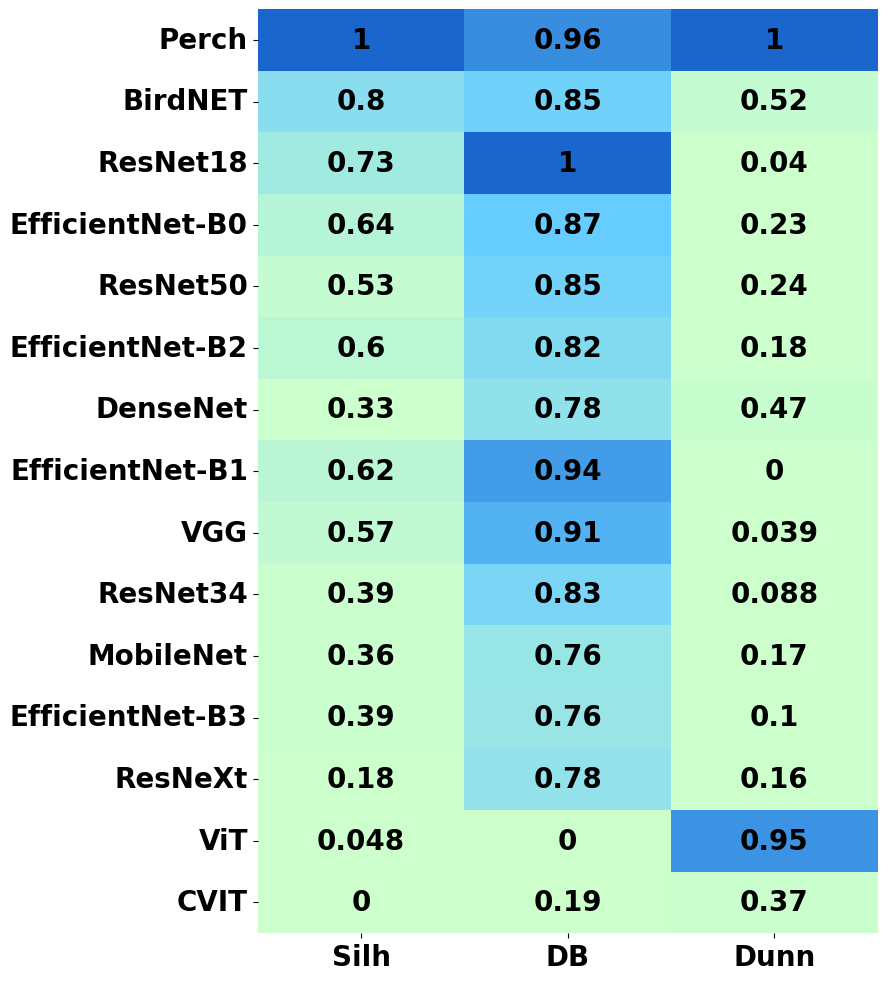

In [108]:
visualize_results(df_svd)

In [113]:
import pandas as pd

# Create a DataFrame from the results
df_reduced = pd.DataFrame(results_reduced).T

In [114]:
# Create a DataFrame from the results
df = pd.DataFrame(results).T

In [116]:
# (score - min): Shifts the minimum value to zero.
# (max - min): Represents the range of the original data.
# Dividing by the range scales all values to [0, 1].

# Normalize scores (higher is better for all)
df_reduced['Silhouette_norm'] = (df_reduced['Silhouette'] - df_reduced['Silhouette'].min()) / (df_reduced['Silhouette'].max() - df_reduced['Silhouette'].min())
df_reduced['Davies-Bouldin_norm'] = 1 - (df_reduced['Davies-Bouldin'] - df_reduced['Davies-Bouldin'].min()) / (df_reduced['Davies-Bouldin'].max() - df_reduced['Davies-Bouldin'].min())
df_reduced['Calinski-Harabasz_norm'] = (df_reduced['Calinski-Harabasz'] - df_reduced['Calinski-Harabasz'].min()) / (df_reduced['Calinski-Harabasz'].max() - df_reduced['Calinski-Harabasz'].min())

# Calculate overall score
df_reduced['Overall_Score'] = (df_reduced['Silhouette_norm'] + df_reduced['Davies-Bouldin_norm'] + df_reduced['Calinski-Harabasz_norm']) / 3

# Sort by overall score
df_sorted_reduced = df_reduced.sort_values('Overall_Score', ascending=False)

print(df_sorted_reduced[['Overall_Score', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']])

                  Overall_Score  Silhouette  Davies-Bouldin  Calinski-Harabasz
bvc                    0.932027    0.168927        2.041688          32.679099
birdnet-realtime       0.915172    0.162381        2.112308          33.056549
densenet               0.874577    0.079552        2.092252          37.949990
resnet18               0.857334    0.066579        1.995957          36.199950
efficientnet-b0        0.733047    0.062078        2.208143          29.181946
efficientnet-b1        0.718473    0.050576        2.163750          28.375870
resnet34               0.713357    0.047112        2.270149          30.062117
efficientnet-b2        0.709536    0.067773        2.306330          28.122770
efficientnet-b3        0.703857    0.074186        2.334912          27.410883
alexnet                0.579778   -0.023106        2.231062          25.042704
resnet50               0.563261    0.059144        2.628556          21.425040
vgg                    0.509997   -0.011895        2

In [115]:
# (score - min): Shifts the minimum value to zero.
# (max - min): Represents the range of the original data.
# Dividing by the range scales all values to [0, 1].

# Normalize scores (higher is better for all)
df['Silhouette_norm'] = (df['Silhouette'] - df['Silhouette'].min()) / (df['Silhouette'].max() - df['Silhouette'].min())
df['Davies-Bouldin_norm'] = 1 - (df['Davies-Bouldin'] - df['Davies-Bouldin'].min()) / (df['Davies-Bouldin'].max() - df['Davies-Bouldin'].min())
df['Calinski-Harabasz_norm'] = (df['Calinski-Harabasz'] - df['Calinski-Harabasz'].min()) / (df['Calinski-Harabasz'].max() - df['Calinski-Harabasz'].min())

# Calculate overall score
df['Overall_Score'] = (df['Silhouette_norm'] + df['Davies-Bouldin_norm'] + df['Calinski-Harabasz_norm']) / 3

# Sort by overall score
df_sorted = df.sort_values('Overall_Score', ascending=False)

print(df_sorted[['Overall_Score', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']])

                  Overall_Score  Silhouette  Davies-Bouldin  Calinski-Harabasz
alexnet                0.939435    0.146197        1.790623          68.460819
bvc                    0.775435    0.180679        1.992654          37.479846
resnet18               0.761060    0.113225        1.885246          51.478492
birdnet-realtime       0.707480    0.162381        2.139925          35.579926
resnet50               0.663874    0.113910        2.175407          43.234823
vgg                    0.653453    0.104222        2.048719          40.952672
efficientnet-b0        0.641015    0.098225        2.042818          40.488656
densenet               0.605978    0.089823        2.174462          40.688568
efficientnet-b1        0.584476    0.072391        1.968489          36.718306
resnet34               0.577956    0.074020        2.138911          39.705782
mobilenet              0.559755    0.085216        2.294127          37.684507
efficientnet-b2        0.555919    0.087638        2

In [95]:
def visualize_results(df):
    # Prepare data for visualization
    metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']
    norm_columns = [f'{metric}_norm' for metric in metrics]
    
    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[norm_columns], annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title('Normalized Scores Heatmap')
    plt.show()
    
    # Radar chart for top 3 models
    top_3 = df.head(3)
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    for idx, model in top_3.iterrows():
        values = model[norm_columns].values
        values = np.concatenate((values, [values[0]]))
        angles_plot = np.concatenate((angles, [angles[0]]))
        ax.plot(angles_plot, values, 'o-', linewidth=2, label=idx)
        ax.fill(angles_plot, values, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, metrics)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Top 3 Models Comparison')
    plt.show()
    
    # Bar plot for Overall Score
    plt.figure(figsize=(12, 6))
    df['Overall_Score'].plot(kind='bar')
    plt.title('Overall Score Comparison')
    plt.xlabel('Models')
    plt.ylabel('Overall Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [57]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, confusion_matrix

for model in model_names:
    # Example embeddings and true labels
    embeddings = model_embeddings[model] # Replace with your actual embeddings
    true_labels = model_labels['resnet18']  # Replace with your actual true labels

    # Perform clustering
    n_clusters = len(np.unique(true_labels))  # Number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pred_labels = kmeans.fit_predict(embeddings)
    
    print (f"Model Name: {model}")
    # Calculate NMI
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    print(f"Normalized Mutual Information (NMI): {nmi}")

    # Calculate ARI
    ari = adjusted_rand_score(true_labels, pred_labels)
    print(f"Adjusted Rand Index (ARI): {ari}")

    # Calculate Cluster Purity
    def cluster_purity(true_labels, pred_labels):
        matrix = confusion_matrix(true_labels, pred_labels)
        purity = np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)
        return purity

    purity = cluster_purity(true_labels, pred_labels)
    print(f"Cluster Purity: {purity}")
    print ('\n')

Model Name: resnet18
Normalized Mutual Information (NMI): 0.6143431384923022
Adjusted Rand Index (ARI): 0.4245017858612495
Cluster Purity: 0.6714285714285714


Model Name: resnet34
Normalized Mutual Information (NMI): 0.6641623451287877
Adjusted Rand Index (ARI): 0.4584870435437788
Cluster Purity: 0.7057142857142857


Model Name: resnet50
Normalized Mutual Information (NMI): 0.701693623817717
Adjusted Rand Index (ARI): 0.6348334985002474
Cluster Purity: 0.8028571428571428


Model Name: efficientnet-b0
Normalized Mutual Information (NMI): 0.667902944117248
Adjusted Rand Index (ARI): 0.5390524855727257
Cluster Purity: 0.7714285714285715


Model Name: efficientnet-b1
Normalized Mutual Information (NMI): 0.7343256277275002
Adjusted Rand Index (ARI): 0.6256232104420157
Cluster Purity: 0.8342857142857143


Model Name: efficientnet-b2
Normalized Mutual Information (NMI): 0.5319684924471011
Adjusted Rand Index (ARI): 0.35901507948377026
Cluster Purity: 0.6628571428571428


Model Name: efficien

In [65]:
# Function to calculate NMI, ARI, and Cluster Purity for a given model
def calculate_metrics(embeddings, true_labels):
    # Convert labels to strings to ensure uniformity
    true_labels = [str(label) for label in true_labels]
    
    n_clusters = len(np.unique(true_labels))  # Number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pred_labels = kmeans.fit_predict(embeddings)
    pred_labels = [str(label) for label in pred_labels]  # Ensure predicted labels are also strings
    
    # Calculate NMI
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    
    # Calculate ARI
    ari = adjusted_rand_score(true_labels, pred_labels)
    
    # Calculate Cluster Purity
    purity = cluster_purity(true_labels, pred_labels)
    
    return nmi, ari, purity

# Function to calculate cluster purity
def cluster_purity(true_labels, pred_labels):
    matrix = confusion_matrix(true_labels, pred_labels)
    purity = np.sum(np.amax(matrix, axis=0)) / np.sum(matrix)
    return purity

# Function to process all models
def process_models(model_names, embeddings_dict, labels_dict):
    results = {}
    for model_name in model_names:
        embeddings = embeddings_dict[model_name]
        true_labels = labels_dict[model_name]
        nmi, ari, purity = calculate_metrics(embeddings, true_labels)
        results[model_name] = {
            'NMI': nmi,
            'ARI': ari,
            'Cluster Purity': purity
        }
    return results

In [66]:
results = process_models(model_names, model_embeddings, model_labels)

In [67]:
# Convert results to DataFrame
df = pd.DataFrame(results).T

# Normalize scores
df['NMI_norm'] = (df['NMI'] - df['NMI'].min()) / (df['NMI'].max() - df['NMI'].min())
df['ARI_norm'] = (df['ARI'] - df['ARI'].min()) / (df['ARI'].max() - df['ARI'].min())
df['Cluster Purity_norm'] = (df['Cluster Purity'] - df['Cluster Purity'].min()) / (df['Cluster Purity'].max() - df['Cluster Purity'].min())

# Calculate overall score
df['Overall_Score'] = (df['NMI_norm'] + df['ARI_norm'] + df['Cluster Purity_norm']) / 3

# Sort by overall score
df_sorted = df.sort_values('Overall_Score', ascending=False)

print(df_sorted[['Overall_Score', 'NMI', 'ARI', 'Cluster Purity']])

                  Overall_Score       NMI       ARI  Cluster Purity
birdnet-realtime       1.000000  0.843078  0.751404        0.900000
vgg                    0.828996  0.779995  0.673894        0.848571
efficientnet-b1        0.730446  0.734326  0.625623        0.834286
bvc                    0.690057  0.749589  0.607851        0.782857
resnet50               0.676489  0.701694  0.634833        0.802857
mobilenet              0.629140  0.683627  0.586817        0.814286
efficientnet-b3        0.580017  0.693114  0.550549        0.777143
efficientnet-b0        0.539261  0.667903  0.539052        0.771429
alexnet                0.462170  0.666851  0.481440        0.734286
resnet34               0.417547  0.664162  0.458487        0.705714
densenet               0.410323  0.635770  0.463798        0.728571
resnet18               0.309045  0.614343  0.424502        0.671429
resnext                0.287219  0.594717  0.368627        0.722857
efficientnet-b2        0.162479  0.531968  0.359

In [84]:
def calculate_overall_score(model_names, embeddings_dict, labels_dict):
    results = {}
    
    for model_name in model_names:
        embeddings = embeddings_dict[model_name]
        true_labels = labels_dict[model_name]
        
        
        # Calculate metrics
        nmi, ari, purity = calculate_metrics(embeddings, true_labels)
        
        results[model_name] = {
            'NMI': nmi,
            'ARI': ari,
            'Cluster Purity': purity
        }
    
    # Convert results to DataFrame
    df = pd.DataFrame(results).T
    
    # Normalize scores
    df['NMI_norm'] = (df['NMI'] - df['NMI'].min()) / (df['NMI'].max() - df['NMI'].min())
    df['ARI_norm'] = (df['ARI'] - df['ARI'].min()) / (df['ARI'].max() - df['ARI'].min())
    df['Cluster Purity_norm'] = (df['Cluster Purity'] - df['Cluster Purity'].min()) / (df['Cluster Purity'].max() - df['Cluster Purity'].min())
    
    # Calculate overall score
    df['Overall_Score'] = (df['NMI_norm'] + df['ARI_norm'] + df['Cluster Purity_norm']) / 3
    
    # Sort by overall score
    df_sorted = df.sort_values('Overall_Score', ascending=False)
    
    return df_sorted[['Overall_Score', 'NMI', 'ARI', 'Cluster Purity']]


def calculate_overall_score_with_svd(model_names, embeddings_dict, labels_dict, n_components=256):
    results = {}
    
    for model_name in model_names:
        embeddings = embeddings_dict[model_name]
        true_labels = labels_dict[model_name]
        
        # Reduce dimensionality using SVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        reduced_embeddings = svd.fit_transform(embeddings)
        
        # Calculate metrics
        nmi, ari, purity = calculate_metrics(reduced_embeddings, true_labels)
        
        results[model_name] = {
            'NMI': nmi,
            'ARI': ari,
            'Cluster Purity': purity
        }
    
    # Convert results to DataFrame
    df = pd.DataFrame(results).T
    
    # Normalize scores
    df['NMI_norm'] = (df['NMI'] - df['NMI'].min()) / (df['NMI'].max() - df['NMI'].min())
    df['ARI_norm'] = (df['ARI'] - df['ARI'].min()) / (df['ARI'].max() - df['ARI'].min())
    df['Cluster Purity_norm'] = (df['Cluster Purity'] - df['Cluster Purity'].min()) / (df['Cluster Purity'].max() - df['Cluster Purity'].min())
    
    # Calculate overall score
    df['Overall_Score'] = (df['NMI_norm'] + df['ARI_norm'] + df['Cluster Purity_norm']) / 3
    
    # Sort by overall score
    df_sorted = df.sort_values('Overall_Score', ascending=False)
    
    return df_sorted[['Overall_Score', 'NMI', 'ARI', 'Cluster Purity']]

In [85]:
# Calculate overall score with SVD
df_sorted = calculate_overall_score(model_names, model_embeddings, model_labels)
df_reduced_sorted = calculate_overall_score_with_svd(model_names, model_embeddings, model_labels)


In [86]:
print(df_sorted)

                  Overall_Score       NMI       ARI  Cluster Purity
birdnet-realtime       1.000000  0.843078  0.751404        0.900000
vgg                    0.828996  0.779995  0.673894        0.848571
efficientnet-b1        0.730446  0.734326  0.625623        0.834286
bvc                    0.690057  0.749589  0.607851        0.782857
resnet50               0.676489  0.701694  0.634833        0.802857
mobilenet              0.629140  0.683627  0.586817        0.814286
efficientnet-b3        0.580017  0.693114  0.550549        0.777143
efficientnet-b0        0.539261  0.667903  0.539052        0.771429
alexnet                0.462170  0.666851  0.481440        0.734286
resnet34               0.417547  0.664162  0.458487        0.705714
densenet               0.410323  0.635770  0.463798        0.728571
resnet18               0.309045  0.614343  0.424502        0.671429
resnext                0.287219  0.594717  0.368627        0.722857
efficientnet-b2        0.162479  0.531968  0.359

In [87]:
print(df_reduced_sorted)

                  Overall_Score       NMI       ARI  Cluster Purity
birdnet-realtime       1.000000  0.843078  0.751404        0.900000
vgg                    0.791781  0.749200  0.673965        0.860000
efficientnet-b1        0.707817  0.734326  0.625623        0.834286
resnet50               0.622888  0.703174  0.605517        0.802857
bvc                    0.587289  0.742755  0.544860        0.777143
efficientnet-b0        0.495973  0.667903  0.539052        0.771429
alexnet                0.406484  0.666851  0.481440        0.734286
resnet34               0.352949  0.664162  0.458487        0.705714
densenet               0.352474  0.635770  0.463798        0.728571
efficientnet-b3        0.248662  0.611268  0.431375        0.682857
resnet18               0.233360  0.614280  0.424332        0.671429
resnext                0.224943  0.594717  0.368627        0.722857
mobilenet              0.218192  0.597495  0.400125        0.691429
cvit                   0.194875  0.606207  0.411

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_results(df):
    # Prepare data for visualization
    metrics = ['NMI', 'ARI', 'Cluster Purity']
    
    # Normalize the scores within the function
    for metric in metrics:
        df[f'{metric}_norm'] = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
    
    norm_columns = [f'{metric}_norm' for metric in metrics]
    
    # Heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[norm_columns], annot=True, cmap='YlGnBu', vmin=0, vmax=1)
    plt.title('Normalized Scores Heatmap')
    plt.show()
    
    # Radar chart for top 3 models
    top_3 = df.head(3)
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    for idx, model in top_3.iterrows():
        values = model[norm_columns].values
        values = np.concatenate((values, [values[0]]))
        angles_plot = np.concatenate((angles, [angles[0]]))
        ax.plot(angles_plot, values, 'o-', linewidth=2, label=idx)
        ax.fill(angles_plot, values, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, metrics)
    ax.set_ylim(0, 1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title('Top 3 Models Comparison')
    plt.show()
    
    # Bar plot for Overall Score
    plt.figure(figsize=(12, 6))
    df['Overall_Score'].plot(kind='bar')
    plt.title('Overall Score Comparison')
    plt.xlabel('Models')
    plt.ylabel('Overall Score')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

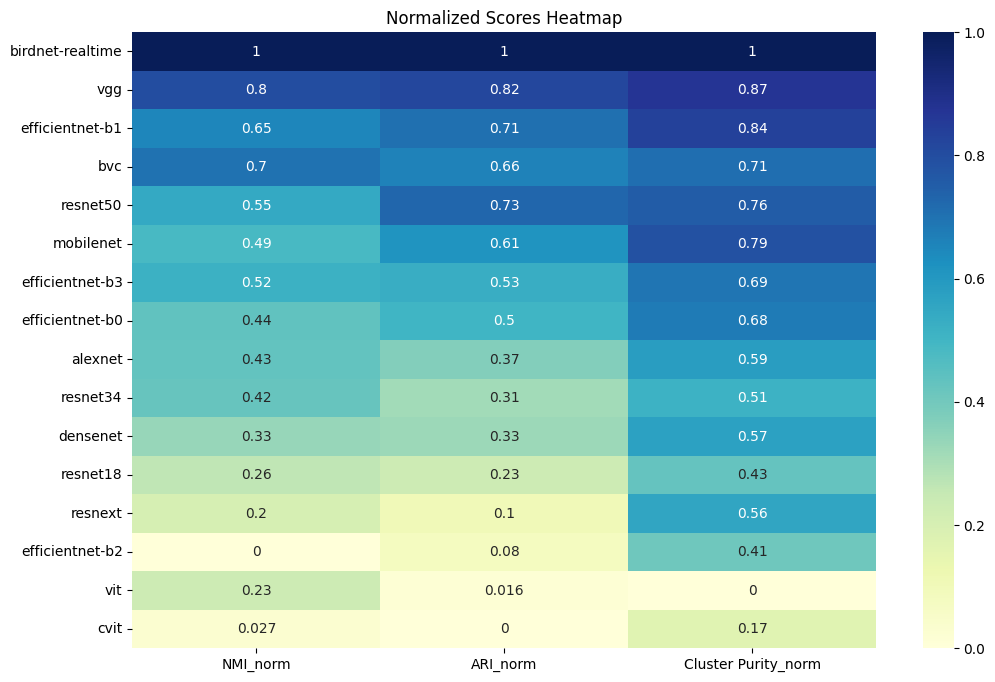

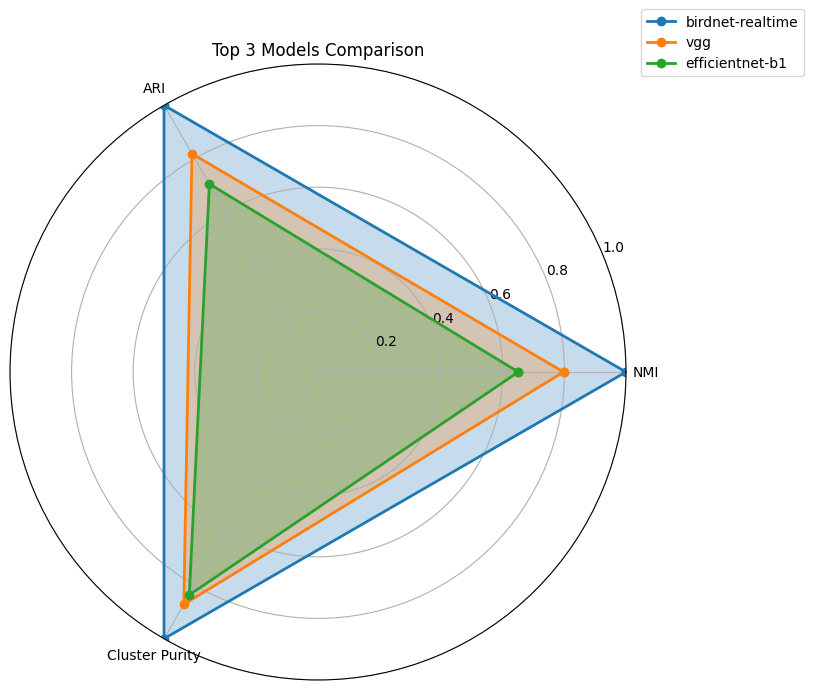

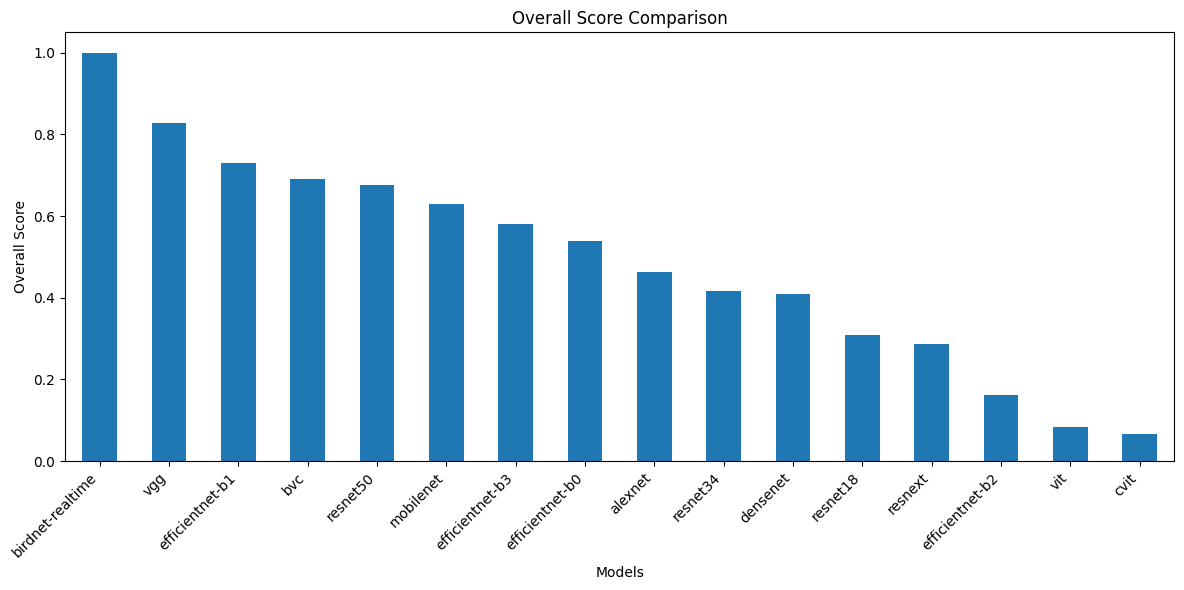

In [93]:
visualize_results(df_sorted)

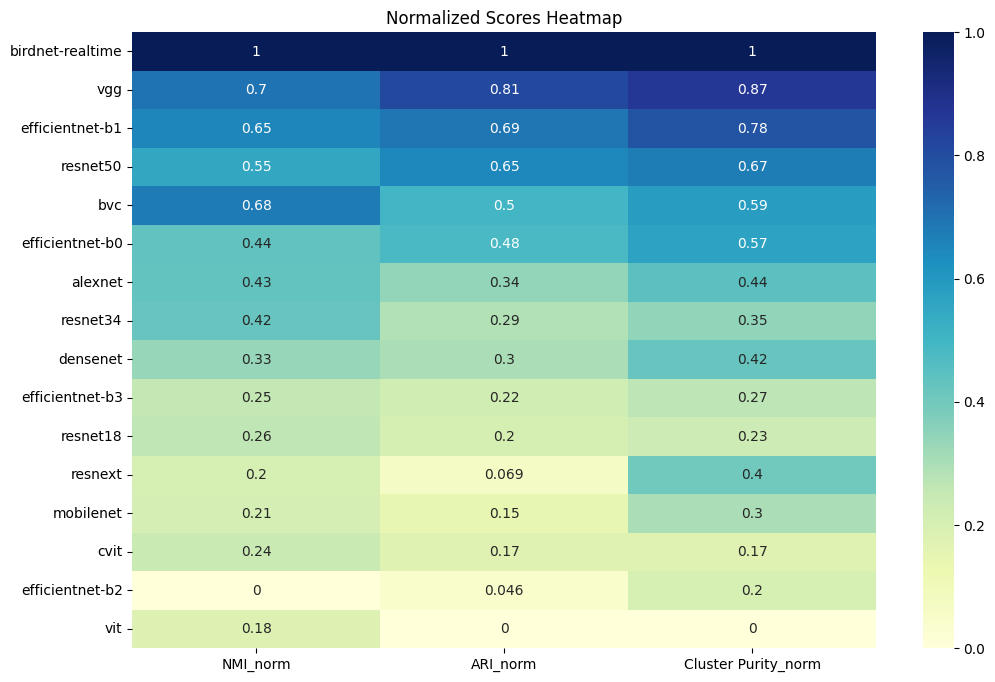

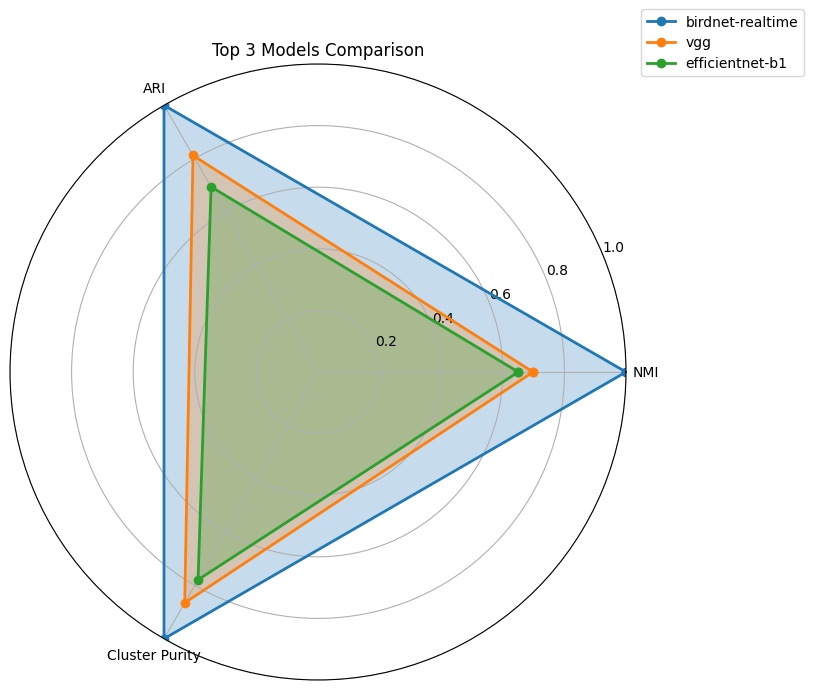

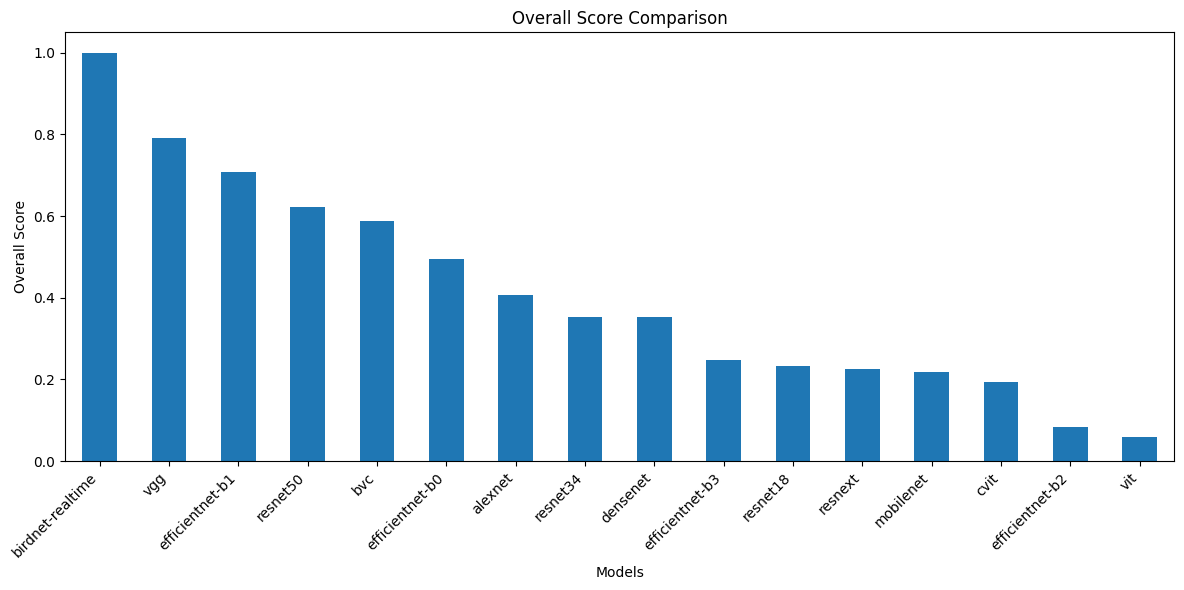

In [94]:
visualize_results(df_reduced_sorted)